In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from calibrated_response.models.variable import ContinuousVariable
from calibrated_response.models.query import (
    ProbabilityEstimate,
    ExpectationEstimate,
    ConditionalProbabilityEstimate,
    ConditionalExpectationEstimate,
    InequalityProposition,
)

In [2]:
# --- Variables ---
variables = [
    ContinuousVariable(name="A", description="Chain variable", lower_bound=0.0, upper_bound=100.0, unit="%"),
    ContinuousVariable(name="B", description="Chain variable", lower_bound=0.0, upper_bound=100.0, unit="%"),
    ContinuousVariable(name="C", description="Chain variable", lower_bound=0.0, upper_bound=100.0, unit="%"),
    ContinuousVariable(name="D", description="Chain variable", lower_bound=0.0, upper_bound=100.0, unit="%"),
    ContinuousVariable(name="E", description="Chain variable", lower_bound=0.0, upper_bound=100.0, unit="%"),
]

# --- Estimates (marginal + conditional cross-links) ---
estimates = [
    ProbabilityEstimate(
        id="A_prior",
        proposition=InequalityProposition(variable="A", 
                                          variable_type="continuous", 
                                          threshold=50.0, 
                                          is_lower_bound=True),
        probability=0.9,
    ),
    # Conditional: E[B | A > 50%] = 5.0%
    #Conditional probability estimate: P(B > 50% | A > 50%) = 0.9
    ConditionalProbabilityEstimate(
        id="AB_prob",
        proposition=InequalityProposition(variable="B", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=True),
        conditions=[InequalityProposition(variable="A", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=True)],
        probability=0.7,
    ),
    ConditionalProbabilityEstimate(
        id="BC_prob",
        proposition=InequalityProposition(variable="C", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=True),
        conditions=[InequalityProposition(variable="B", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=True)],
        probability=0.7,
    ),
    ConditionalProbabilityEstimate(
        id="CD_prob",
        proposition=InequalityProposition(variable="D", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=True),
        conditions=[InequalityProposition(variable="C", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=True)],
        probability=0.7,
    ),
    ConditionalProbabilityEstimate(
        id="DE_prob",
        proposition=InequalityProposition(variable="E", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=True),
        conditions=[InequalityProposition(variable="D", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=True)],
        probability=0.7,
    ),

        ConditionalProbabilityEstimate(
        id="AB_prob_low",
        proposition=InequalityProposition(variable="B", 
                                        variable_type="continuous", 
                                        threshold=30.0, 
                                        is_lower_bound=False),
        conditions=[InequalityProposition(variable="A", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=False)],
        probability=0.99,
    ),
    ConditionalProbabilityEstimate(
        id="BC_prob_low",
        proposition=InequalityProposition(variable="C", 
                                        variable_type="continuous", 
                                        threshold=30.0, 
                                        is_lower_bound=False),
        conditions=[InequalityProposition(variable="B", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=False)],
        probability=0.99,
    ),
    ConditionalProbabilityEstimate(
        id="CD_prob_low",
        proposition=InequalityProposition(variable="D", 
                                        variable_type="continuous", 
                                        threshold=30.0, 
                                        is_lower_bound=False),
        conditions=[InequalityProposition(variable="C", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=False)],
        probability=0.99,
    ),
    ConditionalProbabilityEstimate(
        id="DE_prob_low",
        proposition=InequalityProposition(variable="E", 
                                        variable_type="continuous", 
                                        threshold=30.0, 
                                        is_lower_bound=False),
        conditions=[InequalityProposition(variable="D", 
                                        variable_type="continuous", 
                                        threshold=50.0, 
                                        is_lower_bound=False)],
        probability=0.99,
    ),

]

print(f"{len(variables)} variables, {len(estimates)} estimates")

5 variables, 9 estimates


In [3]:
from calibrated_response.energy_models.markov_random import MarkovRandomField
import jax.numpy as jnp

mrf = MarkovRandomField.from_estimates(variables, estimates, bins_per_var=5)
params_pytree = mrf.zero_params()
params = mrf.pack_params(params_pytree)
energy_fn = mrf.energy_fn_flat
init_x = jnp.zeros(len(variables))  # Initial guess for all variables
energy_value = energy_fn(params, init_x)
print(f"Energy at initial guess: {energy_value}")

Energy at initial guess: 0.0


In [4]:
print(mrf.clique_shapes)
print(mrf.cliques)

[(5,), (5,), (5,), (5,), (5,), (5, 5), (5, 5), (5, 5), (5, 5)]
[(0,), (1,), (2,), (3,), (4,), (0, 1), (1, 2), (2, 3), (3, 4)]


In [8]:
from calibrated_response.maxent_smm.distribution_builder import DistributionBuilder
from calibrated_response.maxent_smm.maxent_solver import JAXSolverConfig

config = JAXSolverConfig(
    num_chains=512,
    num_iterations=5000,
    mcmc_steps_per_iteration=6,
    learning_rate=0.001,

    l2_regularization=1e-5,

    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
    continuous_prior="gaussian",
)

builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=config,
                              energy_fn=energy_fn, init_theta=params)

# Build for target variable "E" (the solver trains once; marginals for all variables are in info)
distribution, info = builder.build(target_variable="E")

print(f"\nConverged: {info['converged']}")
print(f"Features used: {info['n_features']}")
print(f"Skipped: {info['skipped_constraints']}")

Compiled maxent solver
[MaxEntSolver] iter   50  max_err=0.388003  mean_err=0.244813  mean_squared_err=0.078288  accept=0.777  step_size=0.17201
[MaxEntSolver] iter  100  max_err=0.368111  mean_err=0.233809  mean_squared_err=0.071328  accept=0.636  step_size=0.16158
[MaxEntSolver] iter  150  max_err=0.354179  mean_err=0.221764  mean_squared_err=0.065318  accept=0.642  step_size=0.15178
[MaxEntSolver] iter  200  max_err=0.329110  mean_err=0.201452  mean_squared_err=0.054818  accept=0.648  step_size=0.12899
[MaxEntSolver] iter  250  max_err=0.306182  mean_err=0.186646  mean_squared_err=0.047954  accept=0.653  step_size=0.13392
[MaxEntSolver] iter  300  max_err=0.298360  mean_err=0.168135  mean_squared_err=0.040827  accept=0.633  step_size=0.11382
[MaxEntSolver] iter  350  max_err=0.298992  mean_err=0.160622  mean_squared_err=0.040021  accept=0.688  step_size=0.10691
[MaxEntSolver] iter  400  max_err=0.266955  mean_err=0.147610  mean_squared_err=0.032729  accept=0.665  step_size=0.11100
[

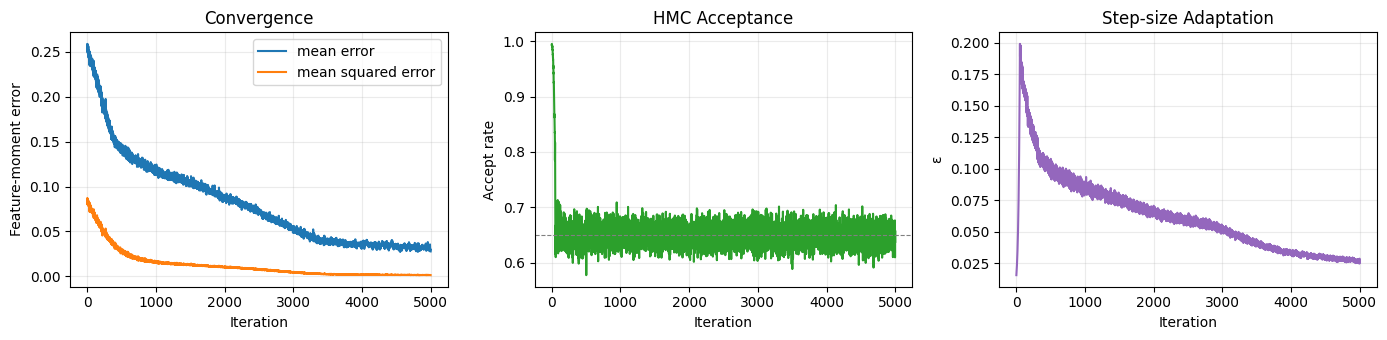

Final max error:  0.05853
Final mean error: 0.02772
Final accept rate: 0.637


In [9]:
history = info["history"]

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

# axes[0].plot(history["iteration"], history["max_error"], label="max error", color="C3")
axes[0].plot(history["iteration"], history["mean_error"], label="mean error", color="C0")
axes[0].plot(history["iteration"], history["mean_squared_error"], label="mean squared error", color="C1")

axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Feature-moment error")
axes[0].set_title("Convergence"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(history["iteration"], history["accept_rate"], color="C2")
axes[1].axhline(config.target_accept_rate, ls="--", color="gray", lw=0.8)
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Accept rate")
axes[1].set_title("HMC Acceptance"); axes[1].grid(alpha=0.25)

axes[2].plot(history["iteration"], history["step_size"], color="C4")
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("ε")
axes[2].set_title("Step-size Adaptation"); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

print(f"Final max error:  {history['max_error'][-1]:.5f}")
print(f"Final mean error: {history['mean_error'][-1]:.5f}")
print(f"Final accept rate: {history['accept_rate'][-1]:.3f}")

In [10]:
energy_model = info["energy_model"]
samples = energy_model.sample(n_samples=2000)

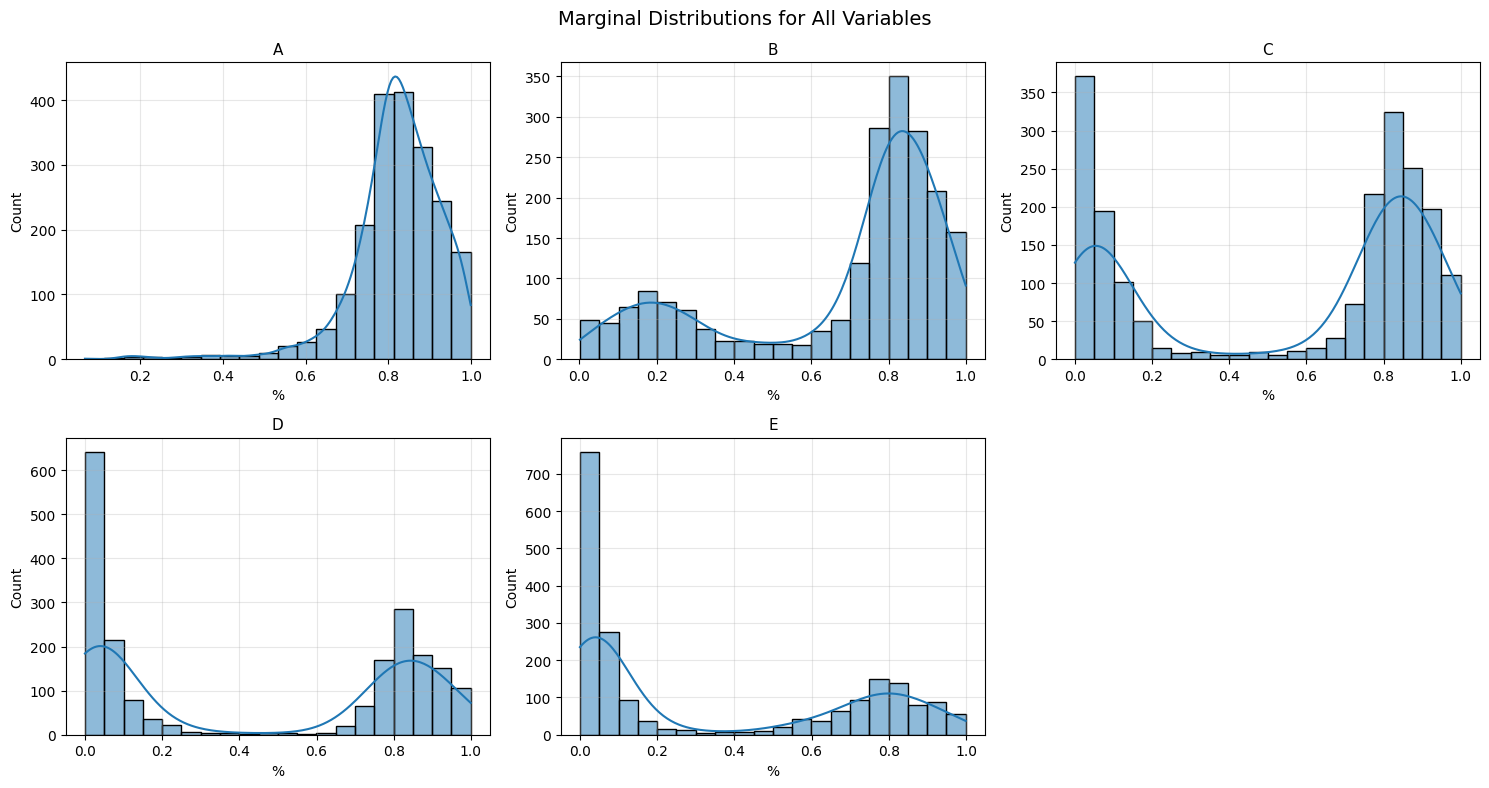

In [11]:
import seaborn as sns
from calibrated_response.models.variable import VariableType

# Plot all marginals in a grid
n_vars = len(variables)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()
    
for idx, var in enumerate(variables):
    if variables[idx].type == VariableType.BINARY:
        sns.histplot(samples[:, idx], bins=[-0.5, 0.5, 1.5], ax=axes[idx], color="C0", alpha=0.6, stat="density")
        # axes[idx].set_xticks([0, 1])
        # axes[idx].set_xticklabels(["False", "True"])
        # axes[idx].hist(samples[:, idx], bins=[-0.5, 0.5, 1.5], color="C0", alpha=0.6, density=True)
    else:
        sns.histplot(samples[:, idx], bins=20, kde=True, ax=axes[idx], color="C0")
        
    axes[idx].set_title(var.name, fontsize=11)
    axes[idx].set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All Variables', fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
import jax.numpy as jnp
for i, var in enumerate(variables):
    print(f"{i}: {var.name}: mean={jnp.mean(samples[:, i]):.3f}, std={jnp.std(samples[:, i]):.3f}")

0: A: mean=0.788, std=0.140
1: B: mean=0.704, std=0.191
2: C: mean=0.617, std=0.287
3: D: mean=0.481, std=0.354
4: E: mean=0.376, std=0.328
